
<h1><div style="text-align: center;"> MSc Artificial Intelligence </div></h1>
<h2><div style="text-align: center;"> Object detection and Instance semantic segmentation -
Pascal VOC
</div></h2>

<h3><div style="text-align: center;"> A Ascencio-Cabral
</div></h3>



## Models

- Faster-RCNN-50-FPN,
- Mask-RCNN-50-FPN
- Mask-RCNN-101-FPN
- Mask-RCNN-101-FPN with customised anchors

### Evaluation - Coco style metrics
 - mean average precision (AP or mAP) at IoU [0.5, 0.05, 0.95], 0.75 and 0.50

This code is based on the following tutorials

- https://learn-pytorch.oneoffcoder.com/object-detection.html
- https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
The folder utility contains code from pytorch with some hacks to track the loss and the average
precision per epoch during training and validation.
- https://github.com/pytorch/vision/tree/master/references/detection

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Comment out if pycocotools is not install
%%capture
!pip install cython
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [3]:
%cd '/content/drive/MyDrive/INM705'

/content/drive/MyDrive/INM705


## 1. Libraries

In [4]:
import os
import pandas as pd
import numpy as np
import random
import cv2
import torch.utils.data
import torch.nn as nn
import torchvision

from torchvision.models.detection.mask_rcnn import MaskRCNN, MaskRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights, \
    maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models import resnet101, ResNet101_Weights
from torchvision.models.detection.backbone_utils import _resnet_fpn_extractor, \
    _validate_trainable_layers
from torchvision.ops import misc as misc_nn_ops
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead

from pascal_dataset import PascalVoc
from utility.engine import train_one_epoch, evaluate
import utility.utils as utils
import utility.transforms as T

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)

## 2. Pascal VOC Dataset

In [ ]:
# uncomment to unzip dataset
# !unzip './data' -d './'

In [5]:
print('Images:', len(os.listdir('data/Images')))
print('Masks:', len(os.listdir('data/GT')))
print('Annotations:', len(os.listdir('data/annotations')))
print('Split txt:', len(os.listdir('Segmentation')))

Images: 2913
Masks: 2913
Annotations: 2913
Split txt: 3


In [6]:
# Example of a process image with boxes and masks
root = os.path.join(os.getcwd(), 'data')
pascal_dataset = PascalVoc(root, transforms=None)
len(pascal_dataset[10][1]['masks'])

6

## 3. Building the models

In [7]:
# VOC Classes
voc_classes= ('__background__','aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
                           'bus','car','cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
                           'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train',
                           'tvmonitor')

###  3.1 Built Mask-RCNN-ResNet-101-FPN

In [8]:
# Maps available devices
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [9]:
def maskrcnn_resnet101_fpn(*, progress=True, num_classes=None,
    weights_backbone=ResNet101_Weights.IMAGENET1K_V2, trainable_backbone_layers=None,
                           **kwargs):
    """
    Adapted from pytorch maskrcnn_resnet50_fpn
    https://pytorch.org/vision/main/_modules/torchvision/models/detection/
    mask_rcnn.html#maskrcnn_resnet50_fpn
    """
    weights_backbone = ResNet101_Weights.verify(weights_backbone)

    if num_classes is None:
        num_classes = 91

    is_trained = weights_backbone is not None
    trainable_backbone_layers = _validate_trainable_layers(is_trained,
                                                           trainable_backbone_layers,
                                                           5, 3)
    norm_layer = misc_nn_ops.FrozenBatchNorm2d if is_trained else nn.BatchNorm2d
    backbone = resnet101(weights=weights_backbone, progress=progress, norm_layer=norm_layer)
    backbone = _resnet_fpn_extractor(backbone, trainable_backbone_layers)
    model = MaskRCNN(
        backbone,
        num_classes=num_classes,
        **kwargs)

    return model

### 3.2 Build the segmentation and detection models

Let's update input features for the predictor and classifier for the models.
Masrcnn-Resnet101-FPN requires first to update the state dictionary with the common parameters in
 the backbone and then create new box and mask predictors for the 21 VOC classes (20 + background).


In [10]:
def get_instance_segmentation_model(num_classes, backbone, custom_anchors=False,
                                    pretrained=True,
                                    task='detection', net_name=None):
    """
    :param num_classes: an integer with the number of classes in the dataset including the
    background
    :param backbone: string with the name of the backbon eto use
    :param custom_anchors: a boolean indicating whether custom anchor should be built
    :param pretrained: a boolean to indicate in the model is pretrained
    :param task: a boolean indicating whether is a detection or segmentation task -
        Faster-RCNN
    :param net_name: a string with name of model to use
    :return:  a deep model
    """
    # load an instance segmentation model pre-trained on COCO
    net = None
    assert backbone in ['resnet-50-fpn', 'resnet-101-fpn' ], \
        'input one of resnet-50-fpn or resnet-101-fpn'

    assert task in ['segmentation', 'detection' ], 'input detection or segmentation'
    if backbone == "resnet-50-fpn" and task == 'segmentation':

        if pretrained:
            net = maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT)
        else:
            net = maskrcnn_resnet50_fpn()

        # get number of input features for the classifier
        in_features = net.roi_heads.box_predictor.cls_score.in_features
        # replace the pre-trained head with a new one
        net.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

        # get the number of input features for the mask classifier
        in_features_mask = net.roi_heads.mask_predictor.conv5_mask.in_channels
        hidden_layer = 256
        # and replace the mask predictor with a new one
        net.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer,
                                                           num_classes)
        net_name = 'maskrcnn-resnet50-fpn'
        print(net_name)

    elif backbone == 'resnet-101-fpn' and task == 'segmentation' and custom_anchors:

        net = maskrcnn_resnet101_fpn(num_classes=num_classes)

        #create a customised anchors for the FPN which by default has 5 outputs
        anchor_generator = AnchorGenerator(
        sizes=tuple([(16, 32, 64, 128, 256, 512) for _ in range(5)]),
        aspect_ratios = tuple([(0.5, 1.0, 2.0) for _ in range(5)]))
        net.rpn.anchor_generator = anchor_generator
        net.rpn.head = RPNHead(256, anchor_generator.num_anchors_per_location()[0])

        # get number of input features for the classifier
        in_features = net.roi_heads.box_predictor.cls_score.in_features
        # replace the pre-trained head with a new one
        net.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        # get the number of input features for the mask classifier
        in_features_mask = net.roi_heads.mask_predictor.conv5_mask.in_channels
        hidden_layer = 256
        # replace the mask predictor with a new one
        net.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer,
                                                           num_classes)
        net_name = 'maskrcnn-resnet101-fpn-ca'
        print(net_name)

    elif backbone == 'resnet-101-fpn' and task == 'segmentation' and not custom_anchors:

        net = maskrcnn_resnet101_fpn(num_classes=num_classes)
        # get the number of input features for the classifier
        in_features = net.roi_heads.box_predictor.cls_score.in_features
        # replace the pre-trained head with a new one -to prevent size clashes
        net.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        #get the number of input features for the mask classifier
        in_features_mask = net.roi_heads.mask_predictor.conv5_mask.in_channels
        hidden_layer = 256
        # replace the mask predictor with a new one
        net.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                          hidden_layer, num_classes)
        net_name = 'maskrcnn-resnet101-fpn'
        print(net_name)

    elif backbone == 'resnet-101-fpn' and task =='detection':
        assert task == 'segmentation', 'Input segmentation'

    else:
        weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
        net = fasterrcnn_resnet50_fpn(weights=weights)
        # get number of input features for the classifier
        in_features = net.roi_heads.box_predictor.cls_score.in_features
        # replace the pre-trained head with a new one
        net.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        net_name = 'fasterrcnn-resnet50-fpn'
        print(net_name)

    return net, net_name

In [11]:
def get_transform(train=True):
    transforms = [T.PILToTensor(), T.ConvertImageDtype(dtype=torch.float32)]
    # converts the image, a PIL image, into a PyTorch Tensor
    if train:
        # during training, randomly flip the training images
        transforms.extend([T.RandomHorizontalFlip(0.5)])
    return T.Compose(transforms)

In [12]:
def plot_stats(stats_dict=None, fig_name=None, optimis=None):
    """
    :param stats_dict: dictionary with the loss and map per epoch
    :param fig_name: name of the plot to save
    :param optimis: string with optimiser used
    """

    fig1 = plt.figure(figsize=(8,4))
    plt.plot(stats_dict['train_loss'], label='training')
    plt.xticks(np.arange(0, len(stats_dict['train_loss']), 2))
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()
    fig1.savefig(f'loss-{fig_name}-{optimis}.png')

    print(' ')

    fig2 = plt.figure(figsize=(8,4))
    plt.plot(stats_dict['map'], label='validation')
    plt.xticks(np.arange(0, len(stats_dict['train_loss']), 2))
    plt.ylabel(' mAP IoU=0.50:0.95')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()
    fig2.savefig(f'map-{fig_name}-{optimis}.png')


## 4. Training and Validation

The dataset will split as the per the  train.txt and val.txt files provided in the VOCKit 2012. The model will be trained and evaluated after each epoch.

In [13]:
from collections import defaultdict

In [14]:
def main(kwargs):

    print("........Starting........")
    num_classes = kwargs['num_classes']
    train_dataset = PascalVoc(kwargs['root'], get_transform(train=True))
    val_dataset = PascalVoc(kwargs['root'], get_transform(train=False))
    train_idx = [i for i, img in enumerate(train_dataset.annot) if img in
                 kwargs['train_list']]
    eval_idx = [i for i, img in enumerate(train_dataset.annot) if img in
               kwargs['val_list']]
    indices = torch.randperm(len(eval_idx)).tolist()
    val_idx = int(len(indices) * 0.4)
    test_idx = indices[val_idx:]
    train_set = torch.utils.data.Subset(train_dataset, train_idx)
    val_set = torch.utils.data.Subset(val_dataset, indices[0: val_idx])

    print(f'{len(train_set)} train subset')
    print(f'{len(val_set)} validation subset')

    # define training and validation data loaders
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=2,
                    shuffle=True, num_workers=2, collate_fn=utils.collate_fn)

    val_loader = torch.utils.data.DataLoader(val_set, batch_size=2, shuffle=False,
                                             num_workers=2, collate_fn=utils.collate_fn)

    # get the model using our helper function
    net, net_name = get_instance_segmentation_model(num_classes,
                                                    backbone=kwargs['backbone'],
                                            custom_anchors=kwargs['anchors'],
                                            task=kwargs['task'])

    # move model to the correct device
    net.to(kwargs['device'])

    # construct an optimizer
    params = [p for p in net.parameters() if p.requires_grad]

    if kwargs['opt'] == "SGD":
        optimizer = torch.optim.SGD(params, lr=kwargs['lr'],
                                  momentum= kwargs['momentum'],
                                    weight_decay=kwargs['w_decay'])
    else:
        optimizer = torch.optim.Adam(params, lr=kwargs['lr'], weight_decay=kwargs['w_decay'])

    # learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=kwargs['gamma'], threshold=0.0001, patience=1)

    #########################
    # Training and validation
    ##########################

    # train_loss =[]
    stats_dict = defaultdict(list)
    epochs = kwargs['epochs']
    lr = kwargs['lr']
    net_name = f'{net_name}-{epochs}-{lr}'
    opt_name = kwargs['opt'].lower()

    if kwargs['resume_training']:
        check_point = torch.load(kwargs['weights_dir'], map_location='cpu')
        net.load_state_dict(check_point['model'])
        optimizer.load_state_dict(check_point['optimizer_dict'])
        s_epoch = check_point['epoch']
        best_ap = check_point['best_ap']
        stats_dict['train_loss'] = check_point['stats']['train_loss']
        stats_dict['map'] = check_point['stats']['map']
        lr_scheduler.load_state_dict(check_point['scheduler'])
        print('resuming')
    else:
        s_epoch = 0
        best_ap = 0

    for epoch in range(s_epoch, epochs):

        # train for one epoch, printing every 100 iterations
        loss, _ = train_one_epoch(net, optimizer, train_loader, kwargs['device'], epoch,
                                  print_freq=100)

        # log loss
        stats_dict['train_loss'].append(loss)

        # evaluate on the test dataset
        _, stats = evaluate(net, val_loader, device=kwargs['device'])

        ap = stats['bbox'][0] if net_name == 'fasterrcnn-resnet50-fpn' else stats['segm'][0]
        stats_dict['map'].append(ap)

        lr_scheduler.step(ap)

        torch.save({'epoch': epoch + 1, 'model': net.state_dict(),
                           'optimizer_dict': optimizer.state_dict(),
                           'scheduler': lr_scheduler.state_dict(),
                            'best_ap': best_ap,
                            'stats': stats_dict}, os.path.join(output_dir,
                                                    f'{net_name}-{opt_name}-resume.pth'))
        if ap > best_ap:
            best_ap = round(ap, 4)

            check_point = {'epoch': epoch + 1, 'model': net.state_dict(),
                           'optimizer_dict': optimizer.state_dict(),
                           'scheduler': lr_scheduler.state_dict(),
                           'best_ap': best_ap, 'test_idx': test_idx}

            torch.save(check_point, os.path.join(output_dir,
                                                 f'best-{net_name}-{opt_name}.pth'))

    # Plot loss per epoch during training
    plot_stats(stats_dict, net_name, opt_name)

    return net_name, test_idx



### 4.2 Hyper-parameters


In [23]:
# hyperparametres
data_path = os.path.join(os.getcwd(), 'data')
output_dir = os.path.join(os.getcwd(), 'weigths')
try:
    os.makedirs(output_dir, exist_ok=False)
    print('Directory successfully created')
except OSError as error:
    print('Directory already exist')

train_images = open('Segmentation/train.txt')
train_list = [f'{line.strip()}.xml' for line in train_images]
val_images = open('Segmentation/val.txt')
val_list = [f'{line.strip()}.xml' for line in val_images]

resume = True
resume_dir = './weigths/maskrcnn-resnet101-fpn-ca-20-0.0001-adam-resume.pth'

# Select Adam or SGD
optims = ['SGD', 'Adam']
tasks = ['detection', 'segmentation']
backbone_name = ['resnet-50-fpn', 'resnet-101-fpn']
params_dict = {'task': tasks[1], 'backbone':backbone_name[1], 'num_classes': 21,
               'anchors': True, 'opt': optims[1], 'root': data_path, 'device': device,
               'train_list': train_list, 'val_list': val_list, 'step': 7, 'gamma':0.2,
               'epochs': 20, 'lr': 0.0001, 'w_decay': 0.0001, 'momentum': 0.9,
               'resume_training': resume, 'weights_dir': resume_dir}

Directory already exist


In [21]:
torch.cuda.empty_cache()

........Starting........
1464 train subset
579 validation subset
maskrcnn-resnet101-fpn-ca
resuming
Epoch: [15]  [  0/732]  eta: 0:06:14  lr: 0.000020  loss: 0.3466 (0.3466)  loss_classifier: 0.0384 (0.0384)  loss_box_reg: 0.1310 (0.1310)  loss_mask: 0.1181 (0.1181)  loss_objectness: 0.0032 (0.0032)  loss_rpn_box_reg: 0.0559 (0.0559)  time: 0.5111  data: 0.2098  max mem: 7362
Epoch: [15]  [100/732]  eta: 0:03:19  lr: 0.000020  loss: 0.4924 (0.4987)  loss_classifier: 0.0659 (0.0758)  loss_box_reg: 0.1359 (0.1635)  loss_mask: 0.1467 (0.1671)  loss_objectness: 0.0123 (0.0149)  loss_rpn_box_reg: 0.0677 (0.0774)  time: 0.3064  data: 0.0075  max mem: 9260
Epoch: [15]  [200/732]  eta: 0:02:45  lr: 0.000020  loss: 0.4220 (0.5114)  loss_classifier: 0.0721 (0.0791)  loss_box_reg: 0.1505 (0.1674)  loss_mask: 0.1494 (0.1706)  loss_objectness: 0.0086 (0.0153)  loss_rpn_box_reg: 0.0591 (0.0790)  time: 0.3126  data: 0.0083  max mem: 9612
Epoch: [15]  [300/732]  eta: 0:02:14  lr: 0.000020  loss: 0.393

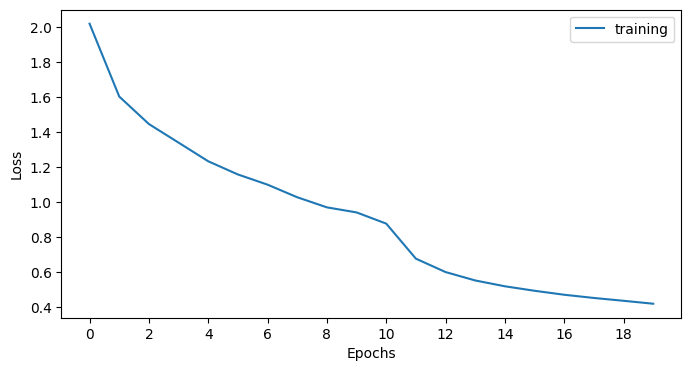

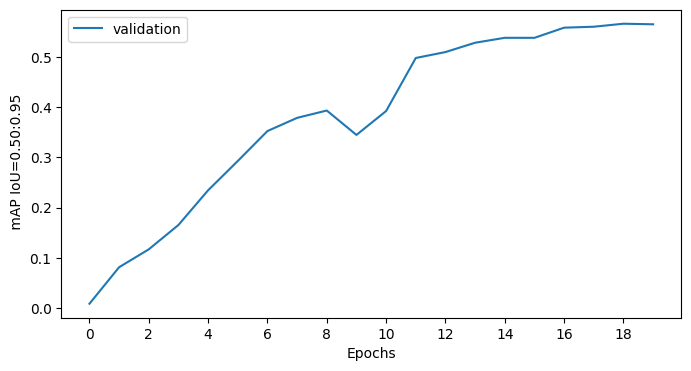

In [24]:
# Run experiment
model_name, test_ind = main(params_dict)

# 5. Evaluation per class - best training weights

In [29]:
voc_dataset = PascalVoc(params_dict['root'], get_transform(train=False))
val = [i for i, img in enumerate(voc_dataset.annot) if img in params_dict['val_list']]
test_dataset = torch.utils.data.Subset(voc_dataset, test_ind)

In [32]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True,
                                         num_workers=2, collate_fn=utils.collate_fn)

In [33]:
# load the trained weights into the model
ep = params_dict['epochs']
step = params_dict['lr']
opt = params_dict['opt'].lower()

checkpoint_dir = os.path.join(output_dir, f'best-{model_name}-{opt}.pth')
checkpoint = torch.load(checkpoint_dir, map_location='cpu')

In [34]:
checkpoint['scheduler']

{'factor': 0.2,
 'min_lrs': [0],
 'patience': 1,
 'verbose': False,
 'cooldown': 0,
 'cooldown_counter': 0,
 'mode': 'max',
 'threshold': 0.0001,
 'threshold_mode': 'rel',
 'best': 0.5664654613556188,
 'num_bad_epochs': 0,
 'mode_worse': -inf,
 'eps': 1e-08,
 'last_epoch': 19,
 '_last_lr': [1.9999999999999958e-05]}

In [35]:
model_, _ = get_instance_segmentation_model(num_classes=21, backbone=params_dict['backbone'],
                                            custom_anchors=params_dict['anchors'], task='segmentation')
model_.load_state_dict(checkpoint['model'], strict=False)

maskrcnn-resnet101-fpn-ca


<All keys matched successfully>

In [36]:
def map_per_class(coco_evaluator, inst_seg=True):
    """
    Code adapted from
    https://github.com/kevalmorabia97/Object-and-Semantic-Part-Detection-pyTorch/blob/
    master/extra/per_class_AP.ipynb
    """
    d = coco_evaluator.coco_eval['bbox'].eval['precision']

    #  All classes except `__background__`
    d_classes = d.shape[2]
    d_ap_class = [np.mean(d[0, :, cl, 0, 2]) for cl in range(d_classes)]
    if inst_seg:
        s = coco_evaluator.coco_eval['segm'].eval['precision']
        s_classes = s.shape[2]
        s_ap_class = [np.mean(s[0, :, cl, 0, 2]) for cl in range(s_classes)]
        return d_ap_class, s_ap_class
    else:
        return d_ap_class

In [37]:
def metric_per_class(dataset, coco_evaluator, inst_seg=True, num_classes=20, fname=None,
                     metrics_dir=None):

    metrics = {}
    if inst_seg:
        d_ap_class, s_ap_class  = map_per_class(coco_evaluator, inst_seg=inst_seg)
        for i in range(0, num_classes):
            cl = dataset.idx_to_class[i+1]
            det = round(100 * d_ap_class[i], 2)
            seg = round(100 * s_ap_class[i], 2)
            print(f'Detection {cl}: {det} | Segmentation {cl}: {seg}')
            metrics[cl] = [det, seg]
        df = pd.DataFrame.from_dict(metrics)
        df.insert(0, 'Model', fname)
        df.insert(1, 'Task', ['detection', 'segmentation'])

    else:
        d_ap_class = map_per_class(coco_evaluator, inst_seg=False)
        for i in range(0, num_classes):
            cl = dataset.idx_to_class[i+1]
            det = round(100 * d_ap_class[i], 2)
            print(f'Detection {cl}: {det}')
            metrics[cl] = [det]
        df = pd.DataFrame.from_dict(metrics)
        df.insert(0, 'Model', fname)
        df.insert(1, 'Task', ['detection'])

    df.to_csv(os.path.join(metrics_dir,  f'{fname}.csv'))
    return df

In [38]:
results_dir = os.path.join(os.getcwd(), 'metrics')
try:
    os.makedirs(results_dir, exist_ok=False)
    print('Directory successfully created')
except OSError as error:
    print('Directory already exist')

Directory already exist


In [39]:
coco_ev, test_stats = evaluate(model_.to(device), test_loader, device=device)

creating index...
index created!
Test:  [  0/218]  eta: 0:02:30  model_time: 0.3216 (0.3216)  evaluator_time: 0.0466 (0.0466)  time: 0.6888  data: 0.3164  max mem: 10103
Test:  [100/218]  eta: 0:00:36  model_time: 0.2716 (0.2602)  evaluator_time: 0.0212 (0.0260)  time: 0.3075  data: 0.0119  max mem: 10103
Test:  [200/218]  eta: 0:00:05  model_time: 0.2394 (0.2607)  evaluator_time: 0.0209 (0.0263)  time: 0.2917  data: 0.0121  max mem: 10103
Test:  [217/218]  eta: 0:00:00  model_time: 0.2325 (0.2592)  evaluator_time: 0.0228 (0.0262)  time: 0.2792  data: 0.0107  max mem: 10103
Test: Total time: 0:01:06 (0.3041 s / it)
Averaged stats: model_time: 0.2325 (0.2592)  evaluator_time: 0.0228 (0.0262)
Accumulating evaluation results...
DONE (t=0.56s).
Accumulating evaluation results...
DONE (t=0.48s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.610
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.856
 Average Precision  (

In [45]:
df_stats = pd.DataFrame.from_dict(test_stats).round(decimals=4)
df_stats.to_csv(os.path.join(results_dir,  f'{model_name}-all_objects-{opt}.csv'))
df_stats

,bbox,segm
0,0.6097,0.5603
1,0.8562,0.8367
2,0.6861,0.6125
3,0.3868,0.4555
4,0.5209,0.4848
5,0.6385,0.5917
6,0.5245,0.4916
7,0.6872,0.6392
8,0.6885,0.6406
9,0.4040,0.4821


In [46]:
segmentation = True if params_dict['task'] == 'segmentation' else False

In [47]:
metrics_df = metric_per_class(voc_dataset, coco_ev, inst_seg=segmentation, num_classes=20,
                              fname=f'{model_name}-{opt}', metrics_dir=results_dir)

Detection aeroplane: 97.11 | Segmentation aeroplane: 97.11
Detection bicycle: 86.02 | Segmentation bicycle: 73.47
Detection bird: 92.59 | Segmentation bird: 94.68
Detection boat: 94.73 | Segmentation boat: 92.53
Detection bottle: 67.88 | Segmentation bottle: 67.88
Detection bus: 89.2 | Segmentation bus: 89.2
Detection car: 87.47 | Segmentation car: 87.47
Detection cat: 89.2 | Segmentation cat: 89.97
Detection chair: 78.35 | Segmentation chair: 69.28
Detection cow: 84.82 | Segmentation cow: 85.93
Detection diningtable: 84.95 | Segmentation diningtable: 69.15
Detection dog: 82.84 | Segmentation dog: 79.87
Detection horse: 88.24 | Segmentation horse: 87.69
Detection motorbike: 92.61 | Segmentation motorbike: 93.85
Detection person: 90.93 | Segmentation person: 90.3
Detection pottedplant: 76.63 | Segmentation pottedplant: 78.02
Detection sheep: 81.53 | Segmentation sheep: 82.42
Detection sofa: 68.6 | Segmentation sofa: 66.41
Detection train: 93.47 | Segmentation train: 94.65
Detection tvmo

In [48]:
metrics_df[['aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
       'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
       'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train',
       'tvmonitor']]

,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,diningtable,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor
0,97.11,86.02,92.59,94.73,67.88,89.2,87.47,89.20,78.35,84.82,84.95,82.84,88.24,92.61,90.93,76.63,81.53,68.60,93.47,85.28
1,97.11,73.47,94.68,92.53,67.88,89.2,87.47,89.97,69.28,85.93,69.15,79.87,87.69,93.85,90.30,78.02,82.42,66.41,94.65,83.53


##  6. Inference

###  6.1 Color map decoding for masks

In [79]:
# This function allows us to visualize a particular segmentation output, by setting
# each pixel color according to the given segmentation class provided in the
# image (segmentation output).
# Adapted from https://learnopencv.com/pytorch-for-beginners-semantic-segmentation-using
# -torchvision/
def decode_segmap(image):

    label_colours = [(128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 255, 255), (255, 255, 0),
               (0, 128, 128), (255, 0, 2550), (80, 70, 180), (250, 80, 190), (64, 128, 0),
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (70, 150, 250), (50, 190, 190)]

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    r[image == 1], g[image == 1], b[image == 1] = label_colours[random.randrange(0, 20)]
    rgb = np.stack([r, g, b], axis=2)
    return rgb, label_colours

In [80]:
def get_prediction(pred, threshold, seg=True, msk_thres=0.5):
    """
    :param pred:  dictionary with the prediction
    :param threshold: float, threshol for detection
    :param seg: boolean, wheter the nference is for a segmentation model or
        detectection only
    :param msk_thres: float threshold for correct ask predictons
    :return:  predictions
    """

    pred_score = list(pred['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(s) for s in pred_score if s>threshold][-1]
    pred_class = [voc_classes[i] for i in list(pred['labels'].cpu().numpy())]
    pred_boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))]
                  for i in list(pred['boxes'].detach().cpu().numpy())]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    pred_score = pred_score[:pred_t+1]
    if seg:
        masks = (pred['masks']>msk_thres).squeeze(1).detach().cpu().numpy()
        pred_masks = masks[:pred_t+1]
        return pred_masks, pred_boxes, pred_class, pred_score
    else:
        return pred_boxes, pred_class, pred_score


def test_inference(img, pred, threshold=0.5, msk_thres=0.5, rect_th=2, text_size=0.5,
                   text_th=1, seg=False):
    """
    :param img: a pil image
    :param pred: a tuple with the predictions
    :param threshold: float boxes thresholds
    :param msk_thres: float mask threshold
    :param rect_th: int thicknes of the rectangle
    :param text_size: float font size
    :param text_th: float the thickness of the test
    :param seg: boolean indicates segmentation or only a detection model
    :return: the image with the inference
    """

    if seg:
        masks, boxes, pred_cls, scores = get_prediction(pred, threshold, seg, msk_thres)
        for i in range(len(masks)):
            rgb_mask, colors = decode_segmap(masks[i])
            img = cv2.addWeighted(np.array(img), 1, rgb_mask, 0.4, 0)
            cv2.rectangle(img, boxes[i][0], boxes[i][1], color=(0, 204, 0),
                          thickness=rect_th)
            s = str(round(scores[i], 2))
            cv2.putText(img, f'{pred_cls[i]}: {s}', (boxes[i][0][0], boxes[i][0][1]-3),
                        cv2.FONT_HERSHEY_SIMPLEX, text_size, color=(0, 204, 0),
                        thickness=text_th, lineType=cv2.LINE_AA)
        return img

    else:
        boxes, pred_cls, scores = get_prediction(pred, threshold, segmentation, msk_thres)
        for i in range(len(boxes)):
            cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 204, 0), thickness=rect_th)
            s = str(round(scores[i], 2))
            cv2.putText(img, f'{pred_cls[i]}: {s}', (boxes[i][0][0], boxes[i][0][1]-3),
                        cv2.FONT_HERSHEY_SIMPLEX, text_size, color=(0, 204, 0),
                        thickness=text_th, lineType=cv2.LINE_AA)
        return img


In [81]:
def show_inference(model, loader, threshold=0.7, mask_thres=0.5, seg=True,
                     outdir=None, fname=None, dataset=voc_dataset):
    """
    :param model: model to evaluate
    :param loader:  constructor with tensors of the test images and targets
    :param threshold: float to select the boxes
    :param mask_thres: float to threshold the masks
    :param seg: boolean to show only mask or boxes and masks
    :param outdir: str directory to save the inference
    :param fname: str name to save the inference
    :param dataset: dataset to test
    :return: save and show predictions and probability scores on the test images
    """

    fig = plt.figure(figsize=(12, 6))
    model = model
    model.eval()

    images, targets = next(iter(loader))
    with torch.no_grad():
        predictions = model(images)
    for i, image in enumerate(images):
        fig.add_subplot(len(images) // 2, 2, i + 1, xticks=[], yticks=[])
        img = torchvision.transforms.ToPILImage()(image)
        img = test_inference(np.array(img), predictions[i], threshold, msk_thres=mask_thres,
                           seg=seg)
        img_id = targets[i]['image_id'].item()
        name = dataset.get_img_name(img_id)
        plt.imshow(img)
        plt.xlabel(name, color='blue', fontsize=10)
    plt.tight_layout()

    if outdir is not None:
        fname = f'predictions_{fname}.png'
        return plt.savefig(os.path.join(outdir, fname), bbox_inches='tight',
                            format='png', dpi=300)

### 6.3 Inference on the test dataset

In [82]:
inference_dir = os.path.join(os.getcwd(), 'inference')
try:
    os.makedirs(inference_dir, exist_ok=False)
    print('Directory successfully created')
except OSError as error:
    print('Directory already exist')

Directory already exist


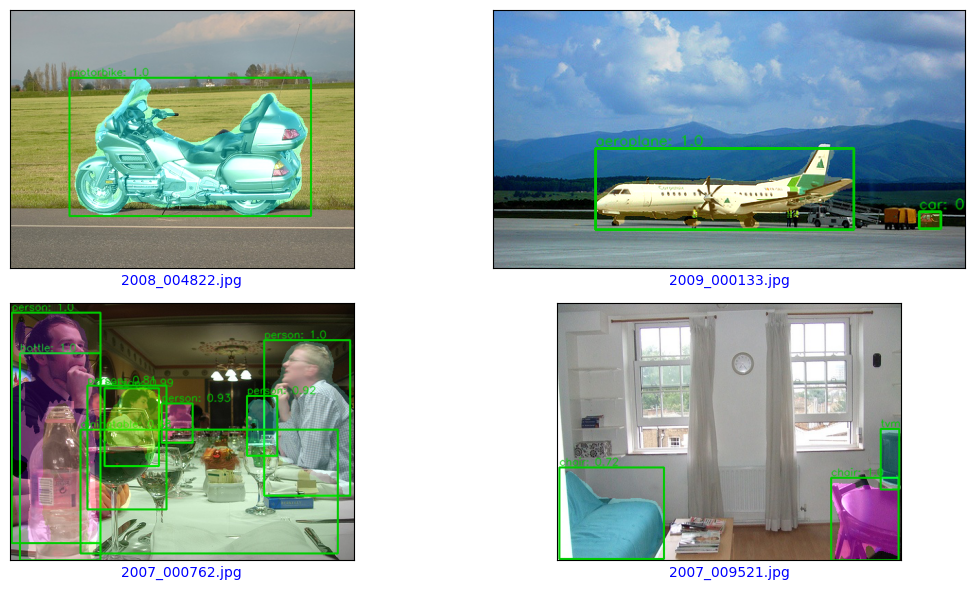

In [84]:
show_inference(model_.to('cpu'), test_loader, threshold=0.5, mask_thres=0.5,
               seg=segmentation, outdir=inference_dir, fname=f'{model_name}-{opt}')